In [1]:
!pip install tensorflow
!pip install keras_preprocessing --upgrade
import pandas as pd
import numpy as np
from tqdm import tqdm
from keras_preprocessing.text import Tokenizer
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
from keras_preprocessing.sequence import pad_sequences
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.8 MB/s eta 0:00:00


Read Dataset

In [2]:
import pandas as pd


file_path = '/path/to/your/file.csv'
data = pd.read_csv("/content/all-data (1).csv", header=None, encoding='latin-1')
data.columns = ["sentiment", "Message"]

data.head()


,sentiment,Message
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [3]:
data.shape

(4846, 2)

In [4]:
data.index = range(4846)
data['Message'].apply(lambda x: len(x.split(' '))).sum()

111989

VISUALIZING THE DATA

In [5]:
!pip install wordcloud
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from wordcloud import WordCloud

def get_sentiment_score(text):
    analysis = TextBlob(str(text))
    return analysis.sentiment.polarity

data['sentiment_score'] = data['Message'].apply(get_sentiment_score)

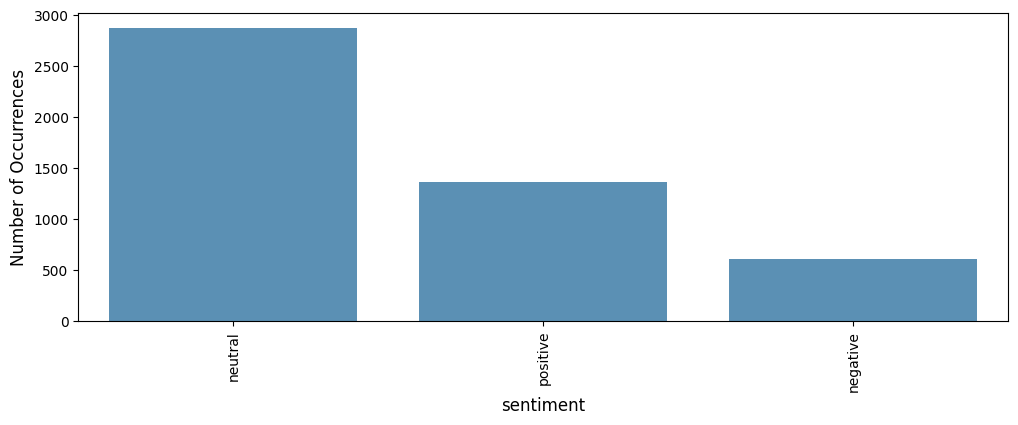

In [6]:
cnt_pro = data['sentiment'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(x=cnt_pro.index, y=cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('sentiment', fontsize=12)
plt.xticks(rotation=90)
plt.show();


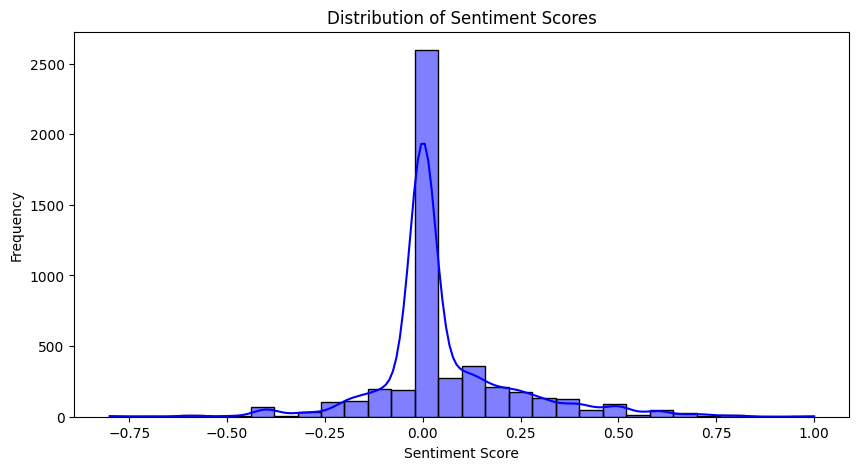

In [7]:
plt.figure(figsize=(10, 5))
sns.histplot(data['sentiment_score'], bins=30, kde=True, color='blue')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()



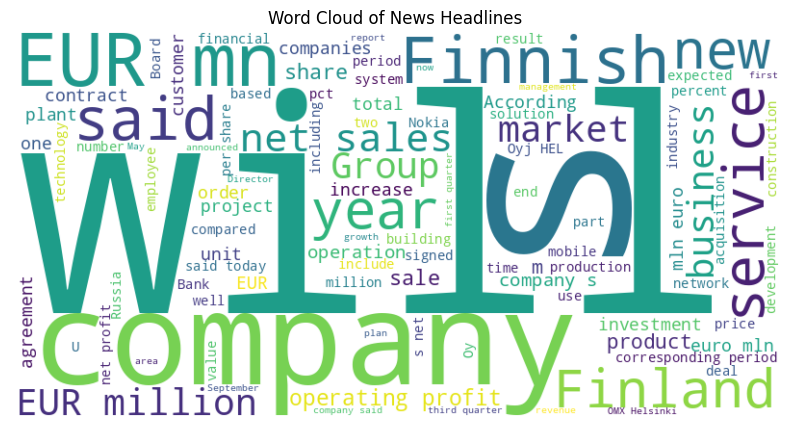

In [8]:
text = ' '.join(data['Message'].astype(str))
wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of News Headlines')
plt.show()

In [9]:
sentiment  = {'positive': 0,'neutral': 1,'negative':2}

data.sentiment = [sentiment[item] for item in data.sentiment]
print(data)

      sentiment                                            Message  \
0             1  According to Gran , the company has no plans t...   
1             1  Technopolis plans to develop in stages an area...   
2             2  The international electronic industry company ...   
3             0  With the new production plant the company woul...   
4             0  According to the company 's updated strategy f...   
...         ...                                                ...   
4841          2  LONDON MarketWatch -- Share prices ended lower...   
4842          1  Rinkuskiai 's beer sales fell by 6.5 per cent ...   
4843          2  Operating profit fell to EUR 35.4 mn from EUR ...   
4844          2  Net sales of the Paper segment decreased to EU...   
4845          2  Sales in Finland decreased by 10.5 % in Januar...   

      sentiment_score  
0            0.000000  
1            0.083333  
2            0.000000  
3           -0.064802  
4            0.000000  
...            

In [10]:
def print_message(index):
    example = data[data.index == index][['Message', 'sentiment']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Message:', example[1])
print_message(12)

A purchase agreement for 7,200 tons of gasoline with delivery at the Hamina terminal , Finland , was signed with Neste Oil OYj at the average Platts index for this September plus eight US dollars per month .
Message: 0


In [11]:
print_message(0)

According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
Message: 1


Text Preprocessing Below we define a function to convert text to lower-case and strip punctuation/symbols from words and so on.

In [12]:
import nltk
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
nltk.download('punkt')

def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text)
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text
data['Message'] = data['Message'].apply(cleanText)
train, test = train_test_split(data, test_size=0.000001 , random_state=42)

def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            #if len(word) < 0:
            if len(word) <= 0:
                continue
            tokens.append(word.lower())
    return tokens

train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Message']), tags=[r.sentiment]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Message']), tags=[r.sentiment]), axis=1)
max_fatures = 500000
MAX_SEQUENCE_LENGTH = 50
tokenizer = Tokenizer(num_words=max_fatures, split=' ', filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(data['Message'].values)
X = tokenizer.texts_to_sequences(data['Message'].values)
X = pad_sequences(X)
print('Found %s unique tokens.' % len(X))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
<ipython-input-12-12f6e5728b32>:12: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "lxml").text


Found 4846 unique tokens.


In [13]:
X = tokenizer.texts_to_sequences(data['Message'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (4846, 50)


In [14]:
train_tagged.values

array([TaggedDocument(words=['unc', 'charlotte', 'would', 'also', 'deploy', 'ssh', 'tectia', 'connector', 'to', 'enable', 'secure', 'application', 'connectivity', '.'], tags=[1]),
       TaggedDocument(words=['in', '2009', ',', 'lee', '&', 'man', 'had', 'a', 'combined', 'annual', 'production', 'capacity', 'of', 'close', 'to', '4.5', 'million', 'tonnes', 'of', 'paper', 'and', '300,000', 'tonnes', 'of', 'pulp', '.'], tags=[1]),
       TaggedDocument(words=['``', 'that', "'s", 'a', 'very', 'high', 'figure', 'on', 'the', 'european', 'scale', ',', '``', 'noop', 'said', ',', 'recalling', 'however', 'that', 'this', 'also', 'includes', 'beer', 'bought', 'by', 'finnish', 'tourists', '.'], tags=[1]),
       ...,
       TaggedDocument(words=['products', 'include', 'consumer', 'electronics', 'devices', 'such', 'as', 'mobile', 'phones', 'and', 'their', 'accessories', ',', 'set-top', 'boes', ',', 'flat', 'panel', 'tvs', 'as', 'well', 'as', 'system', 'solutions', 'products', 'such', 'as', 'infrastruc

Model DM = 1

This work use DM=1 (it preserve word order)

In [15]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from tqdm import tqdm

d2v_model = Doc2Vec(dm=1, dm_mean=1, vector_size=20, window=8, min_count=1, workers=1, alpha=0.065, min_alpha=0.065) # Change 'size' to 'vector_size'
d2v_model.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 4845/4845 [00:00<00:00, 1535313.00it/s]


In [16]:
%%time
for epoch in range(30):
    d2v_model.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    d2v_model.alpha -= 0.002
    d2v_model.min_alpha = d2v_model.alpha

100%|██████████| 4845/4845 [00:00<00:00, 970736.74it/s]


CPU times: user 11.8 s, sys: 122 ms, total: 11.9 s
Wall time: 12.1 s


In [17]:
print(d2v_model)


Doc2Vec<dm/m,d20,n5,w8,s0.001>


In [18]:
len(d2v_model.wv.key_to_index)

11682

In [19]:


embedding_matrix = np.zeros((len(d2v_model.wv.key_to_index) + 1, 20))

for i, vec in enumerate(d2v_model.dv.vectors):
    if i < embedding_matrix.shape[0]:
        embedding_matrix[i] = vec

# Measuring distance between two vectors (related to cosine similarity)

In [20]:
d2v_model.wv.most_similar(positive=['profit'], topn=10)


[('loss', 0.8995051980018616),
 ('income', 0.7995758652687073),
 ('sales', 0.7837308645248413),
 ('profits', 0.7181143164634705),
 ('visits', 0.7103077173233032),
 ('atul', 0.7092036008834839),
 ('zaharova', 0.693539559841156),
 ('franc', 0.6868184804916382),
 ('chopra', 0.6845777630805969),
 ('operations', 0.6655872464179993)]

In [21]:
d2v_model.wv.most_similar(positive=['investment'], topn=10)


[('organization', 0.7873403429985046),
 ('private', 0.7583717107772827),
 ('detailing', 0.7583616971969604),
 ('meats', 0.751440703868866),
 ('ais', 0.7440144419670105),
 ('motorcyclist', 0.7438671588897705),
 ('op-pohjola', 0.736581563949585),
 ('neomarkka', 0.7339686751365662),
 ('syndicated', 0.7318731546401978),
 ('+_land', 0.7115473747253418)]

In [22]:
d2v_model.wv.most_similar(positive=['broke'], topn=10)

[('mold', 0.9669529795646667),
 ('aptly', 0.9065013527870178),
 ('feel', 0.8944047093391418),
 ('warmly', 0.8881998062133789),
 ('www.icis.com', 0.8610854744911194),
 ('glad', 0.8573988080024719),
 ('click', 0.8565745949745178),
 ('my', 0.848547101020813),
 ('eists', 0.8418103456497192),
 ('mika', 0.8369259238243103)]

Plot Similarity word in Doc2vec

# Create the LSTM Model

The parameter used here inspired by [3].



In [23]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding
import tensorflow as tf

model = Sequential()

model.add(Embedding(len(d2v_model.wv.key_to_index) + 1, 20, input_length=X.shape[1], weights=[embedding_matrix], trainable=True))

def split_input(sequence):
     return sequence[:-1], tf.reshape(sequence[1:], (-1,1))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(3,activation="softmax"))
X_shape = X.shape
model.build(input_shape=(None, X_shape[1]))
model.summary()
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=['acc'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 50, 20)              │         233,660 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 50)                  │          14,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │             153 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 248,013 (968.80 KB)

 Trainable params: 248,013 (968.80 KB)

 Non-trainable params: 0 (0.00 B)

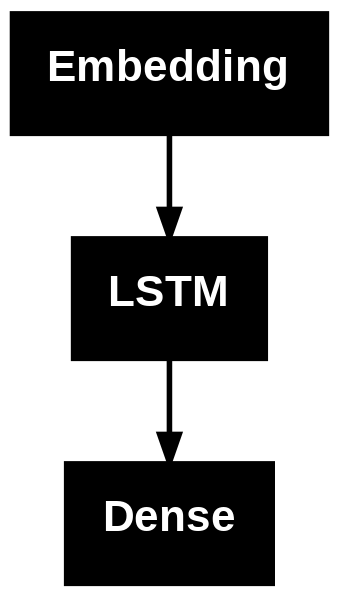

In [24]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [25]:
Y = pd.get_dummies(data['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.15, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(4119, 50) (4119, 3)
(727, 50) (727, 3)


In [26]:
batch_size = 32
history=model.fit(X_train, Y_train, epochs =50, batch_size=batch_size, verbose = 2)

Epoch 1/50
129/129 - 5s - 39ms/step - acc: 0.5897 - loss: 0.5564
Epoch 2/50
129/129 - 3s - 22ms/step - acc: 0.6533 - loss: 0.4768
Epoch 3/50
129/129 - 5s - 40ms/step - acc: 0.7470 - loss: 0.3646
Epoch 4/50
129/129 - 5s - 40ms/step - acc: 0.8084 - loss: 0.2750
Epoch 5/50
129/129 - 3s - 27ms/step - acc: 0.8381 - loss: 0.2263
Epoch 6/50
129/129 - 4s - 34ms/step - acc: 0.8735 - loss: 0.1900
Epoch 7/50
129/129 - 5s - 40ms/step - acc: 0.9128 - loss: 0.1471
Epoch 8/50
129/129 - 6s - 49ms/step - acc: 0.9497 - loss: 0.1048
Epoch 9/50
129/129 - 3s - 22ms/step - acc: 0.9646 - loss: 0.0741
Epoch 10/50
129/129 - 5s - 39ms/step - acc: 0.9721 - loss: 0.0612
Epoch 11/50
129/129 - 6s - 46ms/step - acc: 0.9806 - loss: 0.0452
Epoch 12/50
129/129 - 4s - 33ms/step - acc: 0.9852 - loss: 0.0368
Epoch 13/50
129/129 - 6s - 45ms/step - acc: 0.9891 - loss: 0.0276
Epoch 14/50
129/129 - 4s - 30ms/step - acc: 0.9913 - loss: 0.0234
Epoch 15/50
129/129 - 4s - 31ms/step - acc: 0.9915 - loss: 0.0216
Epoch 16/50
129/129

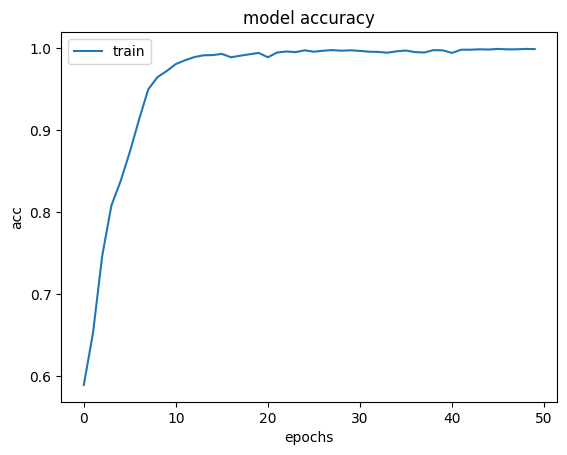

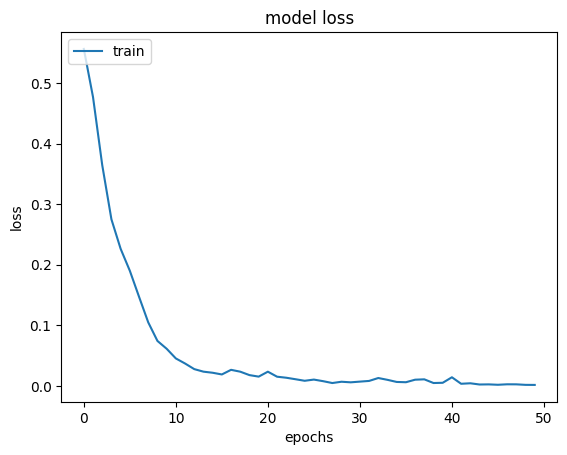

<Figure size 640x480 with 0 Axes>

In [27]:
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_accuracy.png')

plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_loss.png')

In [28]:
_, train_acc = model.evaluate(X_train, Y_train, verbose=2)
_, test_acc = model.evaluate(X_test, Y_test, verbose=2)
print('Train: %.3f, Test: %.4f' % (train_acc, test_acc))

129/129 - 1s - 9ms/step - acc: 0.9995 - loss: 0.0014
23/23 - 0s - 7ms/step - acc: 0.7455 - loss: 1.1437
Train: 1.000, Test: 0.7455


In [30]:
yhat_probs = model.predict(X_test, verbose=0)
print(yhat_probs)
yhat_classes = np.argmax(model.predict(X_test), axis=-1)
print(yhat_classes)

[[4.3252716e-04 9.9956650e-01 9.3334614e-07]
 [1.0191896e-09 9.9999994e-01 3.1742878e-10]
 [6.6960561e-01 9.0178906e-04 3.2949260e-01]
 ...
 [9.8476480e-09 1.0000000e+00 1.7403196e-09]
 [1.2573830e-05 9.9998724e-01 2.3760111e-07]
 [9.9902403e-01 7.7646063e-04 1.9945990e-04]]
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
[1 1 0 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 0 0 0 0 1 0 1 1 1 1 2 1 1 2
 1 1 1 0 1 1 1 0 0 1 1 1 2 1 1 0 2 0 0 1 1 1 1 0 0 0 1 2 1 0 0 1 1 1 0 0 1
 0 1 1 1 1 0 0 0 0 2 0 0 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 2 0 1
 0 2 1 1 0 1 1 0 0 1 1 0 0 1 0 2 1 0 1 1 0 0 1 0 0 0 1 1 0 1 1 2 0 1 1 1 1
 0 1 1 0 1 0 1 0 1 0 2 1 1 1 1 0 1 0 1 1 1 1 1 0 0 0 0 2 1 1 0 1 0 2 1 0 1
 2 0 2 1 1 1 0 0 1 1 0 1 1 0 0 1 1 2 1 1 0 1 1 1 0 1 0 0 1 0 1 1 2 0 1 1 0
 1 1 1 1 1 0 0 1 1 1 1 0 1 2 0 1 2 1 0 1 1 0 1 0 0 1 2 0 1 1 0 0 1 1 1 1 1
 1 1 0 1 0 2 1 2 1 1 1 0 1 2 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 0 1 0 1 0 1 2 1
 1 2 0 1 1 1 1 2 1 1 2 0 1 0 1 2 1 1 1 1 1 1 2 2 2 0 0 1 0 1 1 1 0 1 1 0 1
 0 0 1 1 1

In [31]:
rounded_labels=np.argmax(Y_test, axis=1)
rounded_labels

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1,
       0, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 2, 1, 0, 2, 1, 1, 2, 0, 1, 1, 1,
       0, 2, 0, 1, 0, 1, 1, 1, 0, 2, 1, 0, 1, 1, 1, 1, 0, 0, 2, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 2, 0, 2, 0, 0, 1, 0,
       1, 0, 0, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2,
       1, 0, 2, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 2, 1, 0, 1, 2, 0,
       1, 1, 0, 1, 0, 2, 0, 1, 1, 1, 2, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 2, 2, 0, 0, 1, 0, 1, 0, 1, 2, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 2, 0, 2, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 2, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 2, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 2, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       2, 1, 2, 1, 1, 0, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1,
       0, 1, 2, 1, 0, 1, 0, 2, 2, 1, 1, 1, 0, 0, 0,

In [32]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(rounded_labels, yhat_classes)
cm

array([[150,  59,   7],
       [ 68, 345,  14],
       [ 16,  21,  47]])

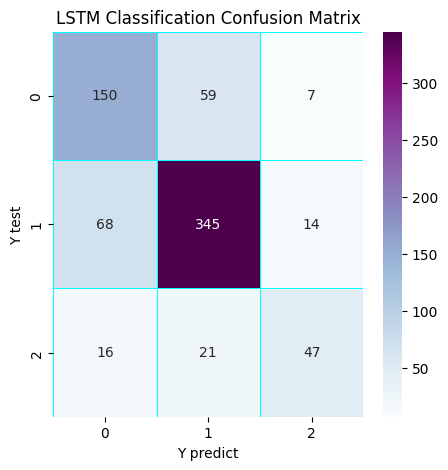

In [33]:

from sklearn.metrics import confusion_matrix
import seaborn as sns

lstm_val = confusion_matrix(rounded_labels, yhat_classes)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(lstm_val, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="BuPu")
plt.title('LSTM Classification Confusion Matrix')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.show()



# Validation

In [34]:
validation_size = 610

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 1, batch_size = batch_size)

print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.7436 - loss: 1.0224 
score: 1.01
acc: 0.75


**Save Model**


In [35]:

model.save('Mymodel.h5')

**Test with new and different data set aside from the data to build the model.**

note : sentiment  = {'positive': 0,'neutral': 1,'negative':2}

In [36]:
message = ['Congratulations! you have won a $1,000 Walmart gift card']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[[4.3031867e-03 9.9564230e-01 5.4474596e-05]] 1


In [37]:
message = ['such massive asteroid hit will certainly create new business opportunities']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[9.9999988e-01 8.8409706e-09 1.2085299e-07]] 0


In [38]:
message = ['so does anyone else not open Snapchat anymore ? or is it just me ... ugh this so sad.']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[3.6269279e-10 1.0000000e+00 1.1302201e-10]] 1


In [39]:
message = ['@elonmusk had a terrible experience with a very pushy sales guy from tesla Stanford shop while shopping for model x']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[[5.6792706e-01 4.3198040e-01 9.2498914e-05]] 0


In [40]:
message = ['The local electronics industry is expected to remain stable amid layoff concerns surrounding Japanese electronics giants operating in the country, an official says.']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[[9.2728919e-10 1.0000000e+00 1.8017857e-10]] 1


In [41]:
message = ['The local electronics industry is amid layoff concerns and last year has laid off tens of employees']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[[3.4506789e-03 1.9519134e-06 9.9654740e-01]] 2


In [42]:
import pickle

with open('financialmodel.pkl', 'wb') as file:
    pickle.dump(model, file)


In [43]:

with open('financialmodel.pkl', 'rb') as file:
    loaded_model = pickle.load(file)


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
